In [4]:
#Imports
library(nnet)
library(mgcv)
#read data
data <- read.csv("/content/red_wine.csv")
head(data)
n <- nrow(data)
#seperate into test, training data
train <- data[1:1000,]
test <- data[1001:n,]
test_X <- subset(test, select = -quality)
test_y <- subset(test, select = quality)

train_X <- subset(train, select = -quality)
train_y <- train$quality



Loading required package: nlme

This is mgcv 1.9-3. For overview type 'help("mgcv-package")'.


Attaching package: ‘mgcv’


The following object is masked from ‘package:nnet’:

    multinom




,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,0
2,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,0
3,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,0
4,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,1
5,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,0
6,7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,0


In [ ]:
# Perform nn with two hidden layer, 0 decay
est_nn <- nnet(train_X,train_y, size=2, decay=0, linout=F, maxit=2000)
summary(est_nn)

# weights:  27
initial  value 273.429292 
iter  10 value 230.916635
iter  20 value 221.333015
iter  30 value 214.943270
...iter 380 value 157.788514
iter 390 value 157.767398
final  value 157.767371 
converged


a 11-2-1 network with 27 weights
options were -
  b->h1  i1->h1  i2->h1  i3->h1  i4->h1  i5->h1  i6->h1  i7->h1  i8->h1  i9->h1 
 -27.66   -0.11    0.66    0.58   -0.04   -0.16    0.00    0.00   29.92   -0.25 
i10->h1 i11->h1 
  -0.37   -0.21 
  b->h2  i1->h2  i2->h2  i3->h2  i4->h2  i5->h2  i6->h2  i7->h2  i8->h2  i9->h2 
 -43.37   -4.86  -56.37   28.17   -2.23   88.36    0.54    0.98  -38.22    8.96 
i10->h2 i11->h2 
  97.95    5.00 
  b->o  h1->o  h2->o 
-27.52 -28.97  33.87 

final  value 126.698559 
converged
[1] "Optimal decay rate:"


[1] 0.3218182

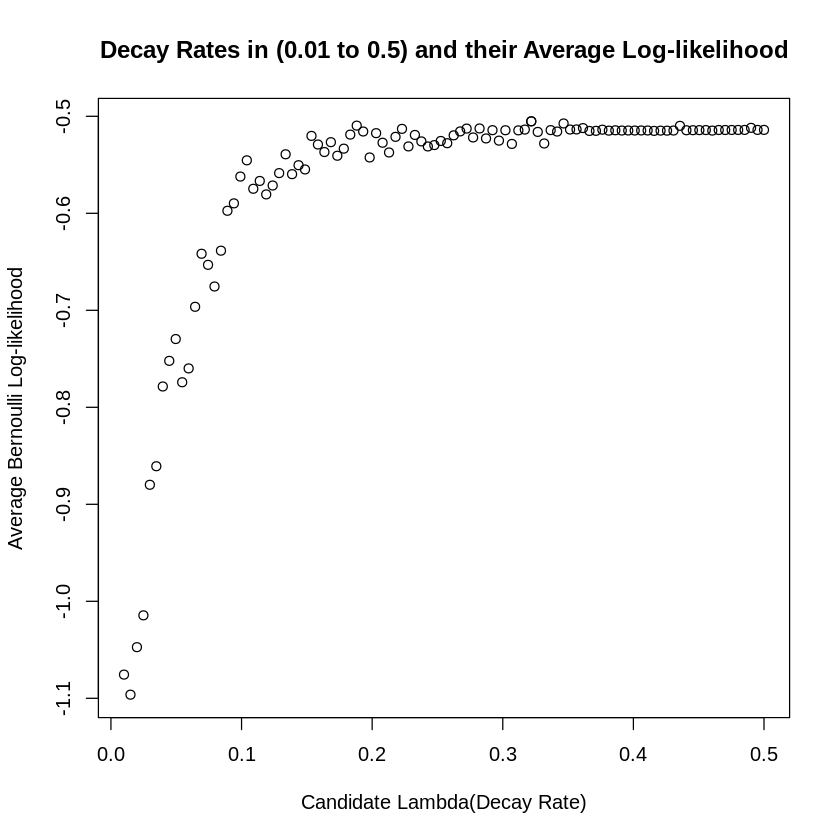

In [ ]:
#standardize training data
train_Xs <- train_X
for(i in 1:ncol(train_Xs)){
  train_Xs[,i] <- (train_X[,i]-mean(train_X[,i]))/sd(train_X[,i])
}

#seperate the training set again to cross validate for lambda:decay rate
y_in <- train_y[1:700]
y_sel <- train_y[701:1000]
X_in <- train_Xs[1:700,]
X_sel <- train_Xs[701:1000,]

#go over a seq of 0.01 to 0.5 for lambda seperated in 100 values
a <- seq(0.01,0.5, length.out = 100)
out <- rep(NA,100)
#cross validate by performing an nn and store the attained loglikelihood of bernoulli
for(i in 1:100){
  est_nn <- nnet(X_in, y_in, size=50, decay=a[i], linout=F, maxit=2000)
  yhat <- predict(est_nn, newdata = X_sel)
  out[i] <- mean(y_sel*log(yhat)+(1-y_sel)*log(1-yhat))
}
#select the lambda that attained the maximum ll from the sequence
optimal_decay <- a[which(out==max(out))]
#plot the candidate lambdas and ll
plot(a,out, xlab = "Candidate Lambda(Decay Rate)", ylab = "Average Bernoulli Log-likelihood", main = "Decay Rates in (0.01 to 0.5) and their Average Log-likelihood")
points(optimal_decay, max(out))
print("Optimal decay rate:")
optimal_decay


In [ ]:
# optimal lambda : 0.321818181818182; it's avg log-likelihood = -0.505163845231006
#Standardize the test data
test_Xs <- test_X
for(i in 1:ncol(test_Xs)){
  test_Xs[,i] <- (test_X[,i]-mean(test_X[,i]))/sd(test_X[,i])
}
arr = rep(NA, 100)
#nn is non-deterministic, so accuracy will vary everytime.
#Run the nn 100 times, and take the max, min, avg accuracy
for(k in c(1:100)){
est_nn <-  nnet(train_Xs, train_y, size=50, decay=optimal_decay, linout=F, maxit=2000)
yhat<- predict(est_nn, test_Xs)
#Assign binary values, depending on whether p_success >/<= 0.5
for(i in c(1:nrow(yhat))){
  if (yhat[i] > 0.5){
    yhat[i] <- 1
  }
  else{
    yhat[i] <- 0
  }
}


arr[k] <- mean(yhat == test_y)
}

print("Maximum accuracy obtained:")
max(arr)
print("Minimum accuracy obtained:")
min(arr)
print("Average accuracy obtained:")
mean(arr)

# weights:  651
initial  value 441.044383 
final  value 168.406739 
converged
[1] "Maximum accuracy obtained:"


[1] 0.754591

[1] "Minimum accuracy obtained:"


[1] 0.7262104

[1] "Average accuracy obtained:"


[1] 0.7407346

In [ ]:
summary(est_nn)

a 11-50-1 network with 651 weights
options were - decay=0.3218182
  b->h1  i1->h1  i2->h1  i3->h1  i4->h1  i5->h1  i6->h1  i7->h1  i8->h1  i9->h1 
   0.00   -0.09   -0.08    0.03   -0.04   -0.07   -0.01   -0.07   -0.13   -0.02 
i10->h1 i11->h1 
   0.02    0.05 
  b->h2  i1->h2  i2->h2  i3->h2  i4->h2  i5->h2  i6->h2  i7->h2  i8->h2  i9->h2 
   0.07   -0.98    0.17   -0.90    0.13    0.25   -0.61   -0.19    0.20    0.72 
i10->h2 i11->h2 
  -0.91    1.06 
  b->h3  i1->h3  i2->h3  i3->h3  i4->h3  i5->h3  i6->h3  i7->h3  i8->h3  i9->h3 
   0.00   -0.09   -0.08    0.03   -0.04   -0.07   -0.01   -0.07   -0.13   -0.02 
i10->h3 i11->h3 
   0.02    0.05 
  b->h4  i1->h4  i2->h4  i3->h4  i4->h4  i5->h4  i6->h4  i7->h4  i8->h4  i9->h4 
   0.00    0.10    0.09   -0.03    0.04    0.07    0.01    0.07    0.13    0.02 
i10->h4 i11->h4 
  -0.02   -0.05 
  b->h5  i1->h5  i2->h5  i3->h5  i4->h5  i5->h5  i6->h5  i7->h5  i8->h5  i9->h5 
   0.00    0.09    0.09   -0.03    0.04    0.07    0.01    0.07    0.

In [5]:
# Perfrom non-parametric logistic additive model
#form the training data
quality <- train_y
train_data <- cbind(train_X, quality)
#non par estimate, logistic link
est_non_par <- gam(quality ~ s(alcohol)+s(sulphates)+s(pH)+s(density)+s(total.sulfur.dioxide)+
  s(free.sulfur.dioxide)+s(chlorides)+s(residual.sugar)+s(citric.acid)+s(volatile.acidity)+s(fixed.acidity), family = binomial, data = train_data)
summary(est_non_par)
#Make prediction ~y
yhat_non_par <- predict(est_non_par, test_X)
#Assign 0/1 on p_success </<= 0.5
for(i in c(1:nrow(yhat_non_par))){
  if (yhat_non_par[i] > 0.5){
    yhat_non_par[i] <- 1
  }
  else{
    yhat_non_par[i] <- 0
  }
}

print("Accuracy of non-parametric additive model:")
#Average correctly predicted, accuracy
mean(yhat_non_par == test_y)


Family: binomial 
Link function: logit 

Formula:
quality ~ s(alcohol) + s(sulphates) + s(pH) + s(density) + s(total.sulfur.dioxide) + 
    s(free.sulfur.dioxide) + s(chlorides) + s(residual.sugar) + 
    s(citric.acid) + s(volatile.acidity) + s(fixed.acidity)

Parametric coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)  0.08857    0.14484   0.611    0.541

Approximate significance of smooth terms:
                          edf Ref.df Chi.sq  p-value    
s(alcohol)              6.903  7.829 45.301  < 2e-16 ***
s(sulphates)            3.538  4.400 43.882  < 2e-16 ***
s(pH)                   2.017  2.602  1.160   0.5537    
s(density)              3.983  4.986 10.203   0.0684 .  
s(total.sulfur.dioxide) 3.228  4.023 31.521 2.07e-06 ***
s(free.sulfur.dioxide)  1.371  1.656  1.552   0.2898    
s(chlorides)            5.391  6.534 11.407   0.1033    
s(residual.sugar)       7.885  8.152 10.873   0.1968    
s(citric.acid)          1.926  2.426  9.250   0.0187 *  
s

[1] "Accuracy of non-parametric additive model:"


[1] 0.7529215